In [129]:
!pip install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.7/57.7 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 6.2 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [471]:
import glob
import re
import pandas as pd
import json
import subprocess
import tqdm
import seaborn as sns
import math
import numpy as np

In [472]:
benchmarks = glob.glob("../benchmarks-new/*.fz")

In [473]:
def timing_out(timing_file):
    try:
        with open(timing_file) as f:
            # print(f)
            data = json.load(f)
            return data["results"][0]["median"]
    except:
        None

In [474]:
names = [x.split(".")[2].split("/")[-1] for x in benchmarks if "factor" not in x]
names

['sum',
 'kepler0',
 'shoelace-formula',
 'add-assoc',
 'himmilbeau',
 'sineOrder3',
 'matrixDeterminant2',
 'rigidBody1',
 'delta4',
 'sqroot',
 'rigidBody2',
 'matrixDeterminant',
 'test01_sum3',
 'kepler1']

In [475]:
def parse_bound(bnd: str):
    bnd = bnd.strip("[]")
    # print("bnd", bnd)
    bnd = bnd.strip()

    if "b" in bnd:
        mantissa = int(bnd.split("b")[0])
        exp = int(bnd.split("b")[1])
        # print("mantissa, exp)
        return mantissa * (2 ** exp)
    else:
        return float(bnd)
    # print(left, right)

In [476]:
parse_gappa_out("../benchmarks-new/sqroot-abs.g.out")

(0.0, 1.0408340855860843e-15)

In [477]:
def parse_gappa_out(filename):
    try:
        with open(filename, "r") as f:
            file = f.read()
        if "Error" in file:
            return None
            
        file = re.sub("\{.*?\}", "", file).strip()
        # try:
        bounds = [parse_bound(x.strip()) for x in file.split("in")[1].strip().split(",")]
        # except as e:
        #     print(file, e)
            # try:
            # except:
            #     print(filename, ":", file)
            
        lb = abs(float(bounds[0]))
        ub = abs(float(bounds[1]))
        return (lb, ub)
        
    except:
        (0,0)

<>:8: SyntaxWarning: invalid escape sequence '\{'
<>:8: SyntaxWarning: invalid escape sequence '\{'
/tmp/ipykernel_126839/295157523.py:8: SyntaxWarning: invalid escape sequence '\{'
  file = re.sub("\{.*?\}", "", file).strip()


In [478]:
def parse_fptaylor_out(filename):
    try:
        with open(filename, "r") as f:
            file = f.read()
            abs_error = None
            rel_error= None
            for line in file.split("\n"):
                if "Absolute error" in line:
                    try:
                        abs_error = float(line.split(":")[1].split()[0])
                    except:
                        print("abs error", line)
                if "Relative error" in line:
                    rel_error = float(line.split(":")[1].split()[0])
                # print(line)
            # print(file)
        return(abs_error, rel_error)
    except:
        None

In [479]:
# file

In [480]:
def sample_post(fname):
    sample = subprocess.run(f"python ../benchmarks-new/{fname}.py", shell=True, check=True, capture_output=True)
    post = float(sample.stdout.strip())
    sampled_bnd = subprocess.run(f"../fuzzrs/target/release/fuzzrs --input ../benchmarks-new/{fname}.fz --post={post}", shell=True, check=True, capture_output=True)
    post_bnd = float(sampled_bnd.stdout.decode().split("\n")[2].split(":")[1].strip())
    post_bnd_abs = max(abs(post) * (math.exp(post_bnd) - 1), abs(post) * (1 - math.exp(-post_bnd)))
    return (post, post_bnd, post_bnd_abs)

In [481]:
results = []
timings = []
post_samples = {}
for fname in tqdm.tqdm(names):
    print(fname)
    with open(f"../benchmarks-new/{fname}.fz.out") as f:
        lines = str(f.read()).split("\n")
        # print(lines)
        pre_rel = lines[0].split(":")[1].strip().replace("Some", "").replace("(", "").replace(")", "")
        pre_abs = lines[1].split(":")[1].strip()

    with open(f"../benchmarks-new/{fname}-factor.fz.out") as f:
        lines = str(f.read()).split("\n")
        # print(lines)
        pre_rel_factor = lines[0].split(":")[1].strip().replace("Some", "").replace("(", "").replace(")", "")
        pre_abs_factor = lines[1].split(":")[1].strip()
        
    g_abs = parse_gappa_out(f"../benchmarks-new/{fname}-abs.g.out")
    if g_abs:
        g_abs = max(*g_abs)
    else:
        g_abs = None
    g_rel = parse_gappa_out(f"../benchmarks-new/{fname}-rel.g.out")
    if g_rel:
        g_rel = max(*g_rel)
    else:
        g_rel = None

    fptaylor_abs, fptaylor_rel = parse_fptaylor_out(f"../benchmarks-new/{fname}.fptaylor.out")
    result = {
        "benchmark": fname,
        "pre-rel": pre_rel,
        "pre-abs": pre_abs,
        "pre-rel-factor": pre_rel_factor,
        "pre-abs-factor": pre_abs_factor,
        "gappa-abs": g_abs,
        "gappa-rel": g_rel,
        "fptaylor-abs": fptaylor_abs,
        "fptaylor-rel": fptaylor_rel,
    }
    timing = {
        "benchmark": fname,
        "gappa-abs": timing_out(f"../benchmarks-new/{fname}-abs.g.json"),
        "gappa-rel": timing_out(f"../benchmarks-new/{fname}-rel.g.json"),
        "numfuzz": timing_out(f"../benchmarks-new/{fname}.fz.json"),
        "numfuzz-factor": timing_out(f"../benchmarks-new/{fname}-factor.fz.json"),
        "fptaylor-rel": timing_out(f"../benchmarks-new/{fname}-rel.fptaylor.json"),
        "fptaylor-abs": timing_out(f"../benchmarks-new/{fname}-abs.fptaylor.json"),
    }
    results.append(result)
    timings.append(timing)

    samples = [sample_post(fname) for _ in range(10000)]
    post_samples[fname] = samples
    # print(result)

  0%|                                                                                                                                                  | 0/14 [00:00<?, ?it/s]

sum


  7%|█████████▋                                                                                                                             | 1/14 [04:40<1:00:43, 280.27s/it]

kepler0


 14%|███████████████████▎                                                                                                                   | 2/14 [10:03<1:01:09, 305.83s/it]

shoelace-formula


 21%|█████████████████████████████▎                                                                                                           | 3/14 [15:09<56:02, 305.73s/it]

add-assoc


 29%|███████████████████████████████████████▏                                                                                                 | 4/14 [19:25<47:39, 285.96s/it]

himmilbeau


 36%|████████████████████████████████████████████████▉                                                                                        | 5/14 [24:02<42:24, 282.67s/it]

sineOrder3


 43%|██████████████████████████████████████████████████████████▋                                                                              | 6/14 [28:31<37:06, 278.26s/it]

matrixDeterminant2


 50%|████████████████████████████████████████████████████████████████████▌                                                                    | 7/14 [34:08<34:42, 297.48s/it]

rigidBody1


 57%|██████████████████████████████████████████████████████████████████████████████▎                                                          | 8/14 [39:06<29:44, 297.43s/it]

delta4


 64%|████████████████████████████████████████████████████████████████████████████████████████                                                 | 9/14 [44:56<26:09, 313.83s/it]

sqroot


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                                      | 10/14 [50:06<20:50, 312.68s/it]

rigidBody2


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                             | 11/14 [55:35<15:53, 317.81s/it]

matrixDeterminant


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 12/14 [1:01:06<10:43, 321.94s/it]

test01_sum3


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍         | 13/14 [1:05:36<05:05, 305.93s/it]

kepler1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 14/14 [1:11:35<00:00, 306.85s/it]


In [482]:
results_df = pd.DataFrame(results)
results_transpose = results_df.transpose()
results_transpose.columns = results_transpose.iloc[0]
results_df

,benchmark,pre-rel,pre-abs,pre-rel-factor,pre-abs-factor,gappa-abs,gappa-rel,fptaylor-abs,fptaylor-rel
0,sum,None,2.6645352591003757e-14,None,1.3322676295501878e-14,6.661338e-15,NaN,4.440893e-15,1.010807e-15
1,kepler0,None,9.53407663928374e-13,None,6.810054742345528e-13,1.982414e-13,NaN,1.170612e-13,2.433767e-15
2,shoelace-formula,None,3.996806885453452e-9,None,1.998403442726726e-9,NaN,NaN,NaN,NaN
3,add-assoc,6.661338147750937e-16,2.6645352591003757e-12,4.440892098500625e-16,1.7763568394002505e-12,1.364242e-12,6.661338e-16,9.094948e-13,2.220447e-15
4,himmilbeau,None,1.1224354778960333e-11,None,5.986322548778844e-12,2.000178e-12,NaN,1.179501e-12,NaN
5,sineOrder3,None,5.937035405398565e-15,None,4.2407393152643635e-15,2.068635e-15,NaN,9.205780e-16,NaN
6,matrixDeterminant2,None,2.2648549702353193e-11,None,6.661338147750939e-12,7.005951e-12,NaN,3.126389e-12,NaN
7,rigidBody1,None,9.79216707719388e-13,None,8.160139230994901e-13,5.897505e-13,NaN,4.263257e-13,NaN
8,delta4,None,1.1438511683081742e-12,None,5.004348861348262e-13,1.767546e-13,NaN,1.154146e-13,NaN
9,sqroot,3.774758283725525e-15,4.85722573273506e-15,1.332267629550187e-15,1.734723475976807e-15,1.040834e-15,1.201531e-15,9.714452e-16,8.883149e-16


In [483]:
post_samples

{'sum': [(4.788487842935605, 6.217248937900896e-15, 2.977122095564265e-14),
  (4.129853895068527, 6.883382752675994e-15, 2.8427365072386375e-14),
  (4.929330963806649, 6.10622663543838e-15, 3.064687769928879e-14),
  (4.974659011459453, 6.10622663543838e-15, 3.092869345541531e-14),
  (3.8561312803558145, 7.32747196252606e-15, 2.8255693840626845e-14),
  (3.990032698608134, 7.105427357601027e-15, 2.8350887494412787e-14),
  (5.153898631449191, 5.884182030513347e-15, 3.0898675406982465e-14),
  (4.365316452254845, 6.661338147750961e-15, 2.907884901040999e-14),
  (3.462657771247108, 7.882583474838643e-15, 2.7679121165057528e-14),
  (4.589492117494881, 6.4392935428259284e-15, 2.955308695703519e-14),
  (5.016870553961716, 5.9952043329758635e-15, 3.007716408309021e-14),
  (4.596390618197372, 6.4392935428259284e-15, 2.959750842806392e-14),
  (4.690754479029755, 6.328271240363412e-15, 3.0205145027798e-14),
  (4.765873981681003, 6.217248937900896e-15, 2.963062495077564e-14),
  (3.6999570059947815, 

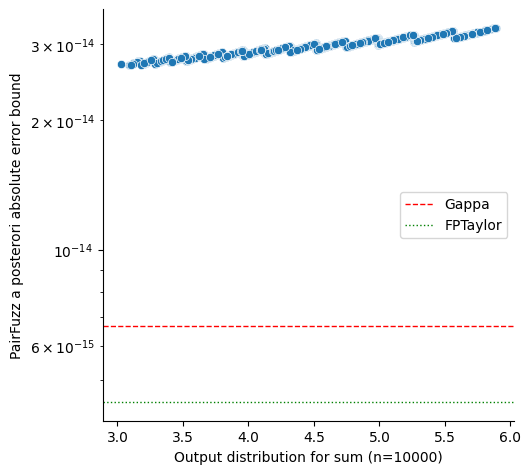

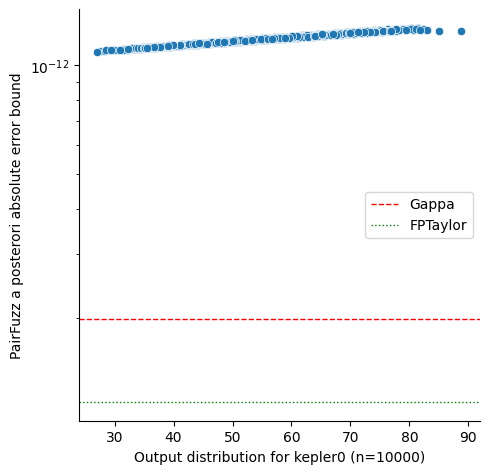

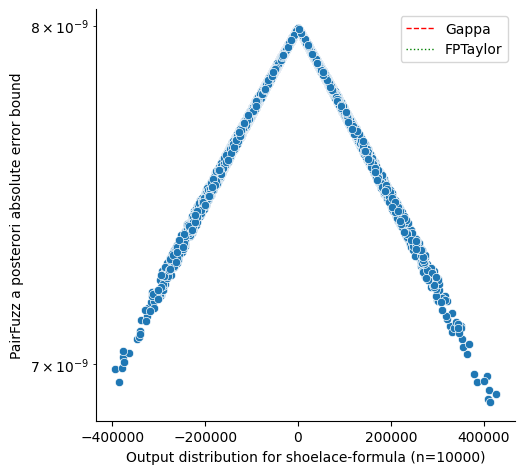

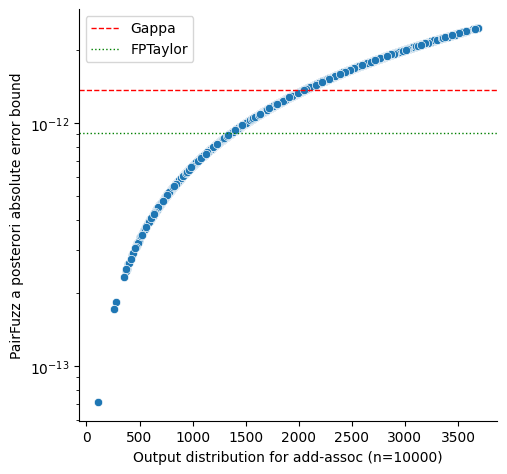

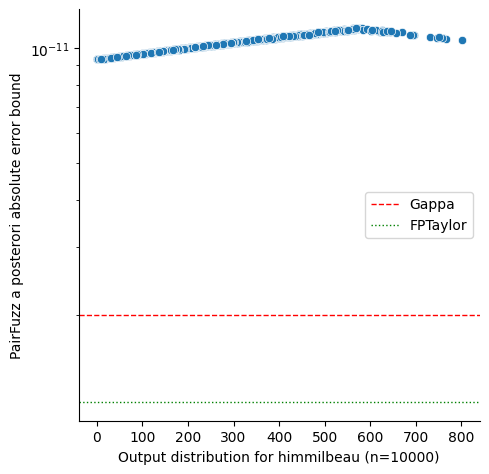

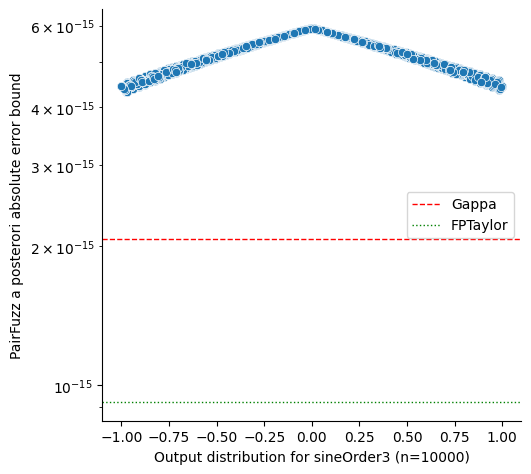

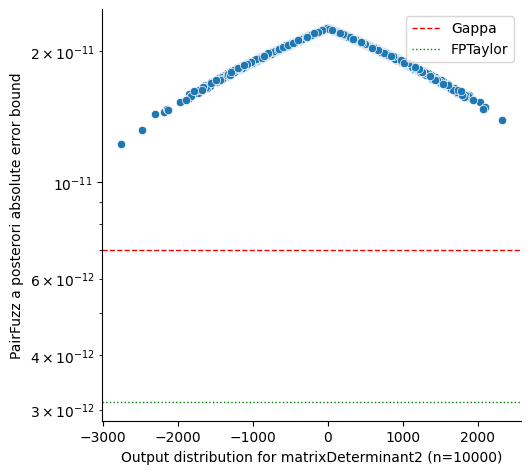

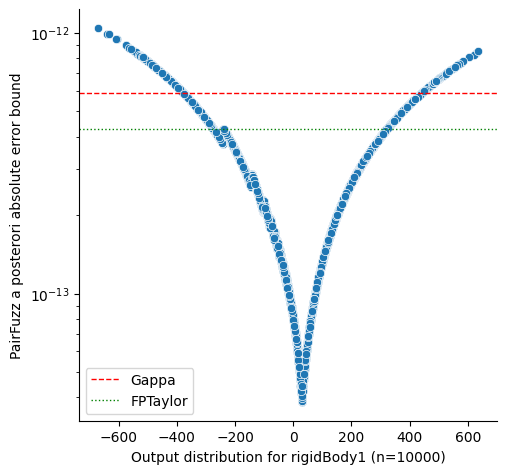

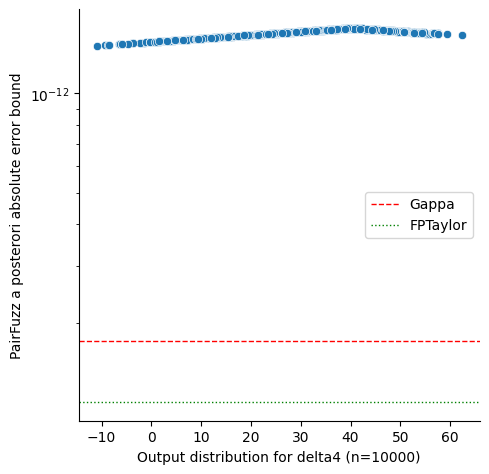

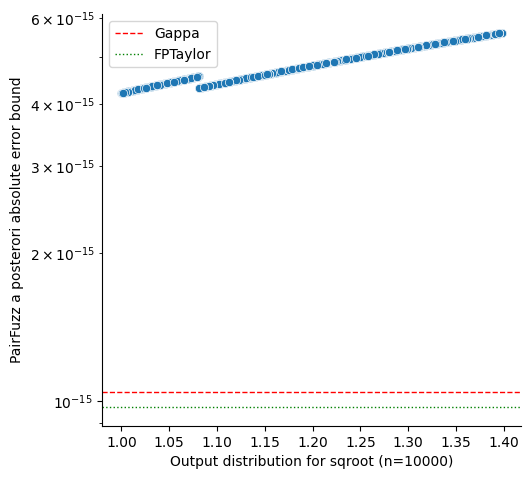

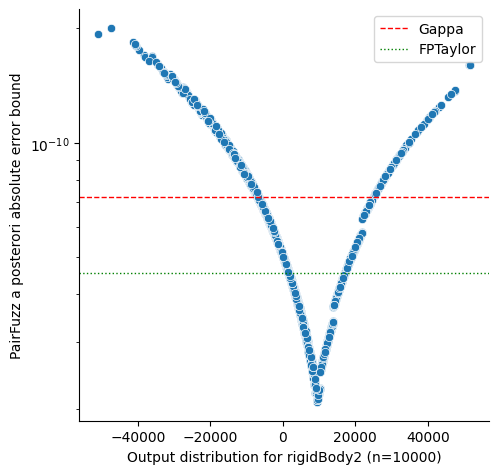

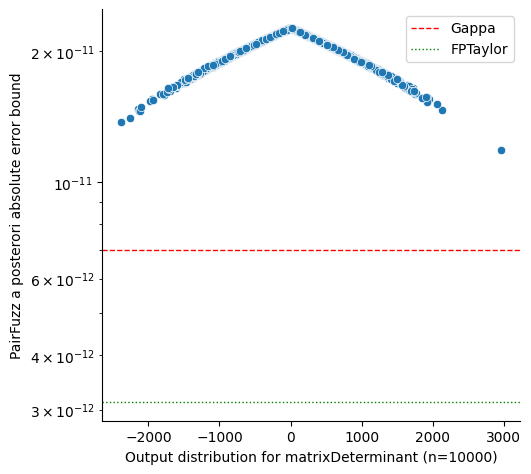

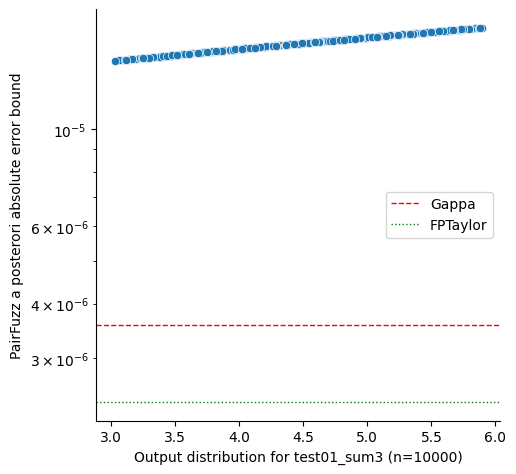

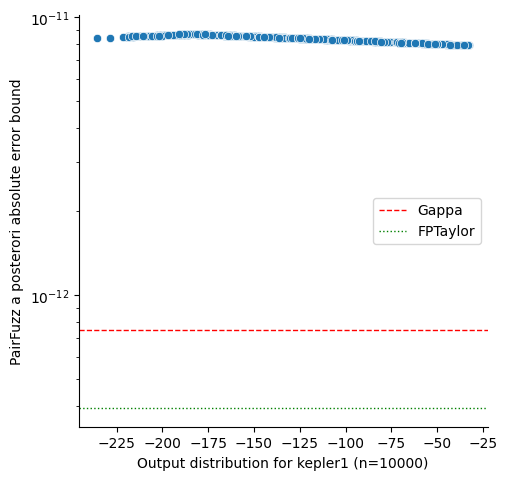

In [484]:
for fname in names:
    # samples_df = pd.DataFrame(post_samples[fname], columns = ["result", "error-bound-rel", "error-bound-abs"])
    # gappa_abs = results_transpose[fname]["gappa-abs"]
    # gappa_rel = results_transpose[fname]["gappa-rel"]
    # # convert to rel
    # g = sns.jointplot(samples_df, x = "result", y = "error-bound-rel", kind="scatter", marginal_kws={"fill": True, "bins": 30})
    # g.savefig(f"{fname}.svg")
    samples_df = pd.DataFrame(post_samples[fname], columns = ["result", "error-bound-rel", "error-bound-abs"])
    gappa_abs = results_transpose[fname]["gappa-abs"]
    gappa_rel = results_transpose[fname]["gappa-rel"]
    fptaylor_abs = results_transpose[fname]["fptaylor-abs"]
    numfuzz_abs = results_transpose[fname]["pre-abs-factor"]
    # convert to rel
    g = sns.relplot(samples_df, x = "result", y = "error-bound-abs")
    g.set_axis_labels(f"Output distribution for {fname} (n={len(samples_df)})", "PairFuzz a posterori absolute error bound")
    ax = g.ax
    ax.axhline(y=gappa_abs, linestyle="--", color="red", linewidth=1, label="Gappa")
    ax.axhline(y=fptaylor_abs, linestyle=":", color="green", linewidth=1, label="FPTaylor")
    # ax.axhline(y=numfuzz_abs, linestyle="dashdot", color="brown", linewidth=1, label="PairFuzz (a priori)")
    ax.legend()
    g.set(yscale="log")
    g.savefig(f"{fname}.pdf")

In [492]:
results_df = pd.DataFrame(results)

In [500]:
timings_df = pd.DataFrame(timings)
timings_df.to_csv("timings-2025-11-13.csv")

In [501]:
cols = ["pre-rel","pre-abs", "pre-rel-factor", "pre-abs-factor", "gappa-abs", "gappa-rel", "fptaylor-abs", "fptaylor-rel"]

In [502]:
decimals = pd.Series([4,4,4,4,4,4,4,4], index=cols)

In [503]:
results_df[cols] = results_df[cols].replace({"None": np.nan}).astype("float64")

In [504]:
for col in cols:
    results_df[col] = results_df[col].apply(lambda x : f'{x:.4g}')

In [505]:
results_df.replace({"nan" : ""}).to_csv("results-2025-11-13.csv")

In [499]:
results_df

,benchmark,pre-rel,pre-abs,pre-rel-factor,pre-abs-factor,gappa-abs,gappa-rel,fptaylor-abs,fptaylor-rel
0,sum,nan,2.665e-14,nan,1.332e-14,6.661e-15,nan,4.441e-15,1.011e-15
1,kepler0,nan,9.534e-13,nan,6.81e-13,1.982e-13,nan,1.171e-13,2.434e-15
2,shoelace-formula,nan,3.997e-09,nan,1.998e-09,nan,nan,nan,nan
3,add-assoc,6.661e-16,2.665e-12,4.441e-16,1.776e-12,1.364e-12,6.661e-16,9.095e-13,2.22e-15
4,himmilbeau,nan,1.122e-11,nan,5.986e-12,2e-12,nan,1.18e-12,nan
5,sineOrder3,nan,5.937e-15,nan,4.241e-15,2.069e-15,nan,9.206e-16,nan
6,matrixDeterminant2,nan,2.265e-11,nan,6.661e-12,7.006e-12,nan,3.126e-12,nan
7,rigidBody1,nan,9.792e-13,nan,8.16e-13,5.898e-13,nan,4.263e-13,nan
8,delta4,nan,1.144e-12,nan,5.004e-13,1.768e-13,nan,1.154e-13,nan
9,sqroot,3.775e-15,4.857e-15,1.332e-15,1.735e-15,1.041e-15,1.202e-15,9.714e-16,8.883e-16


## Break

In [367]:
parse_fptaylor_out(f"../benchmarks-new/{fname}.fptaylor.out")

(None, None)

In [368]:
parse_fptaylor_out(f"../benchmarks-new/kepler0.fptaylor.out")

(None, None)

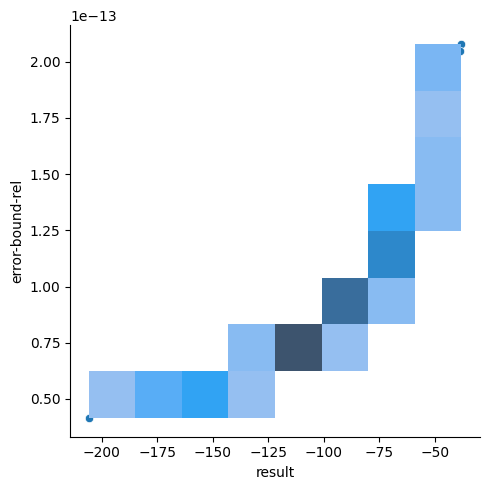

In [283]:
samples_df = pd.DataFrame(post_samples[fname], columns = ["result", "error-bound-rel", "error-bound-abs"])
gappa_abs = results_transpose[fname]["gappa-abs"]
gappa_rel = results_transpose[fname]["gappa-rel"]
# convert to rel
g = sns.relplot(samples_df, x = "result", y = "error-bound-rel")
g.set_axis_labels(f"Output distribution for {fname}", "A posterori relative error bound")
# g.map_dataframe(
#     sns.histplot, x="result", y = "error-bound-rel" # fill=True, levels=100, common_norm=True
# )
g.savefig(f"{fname}.svg")

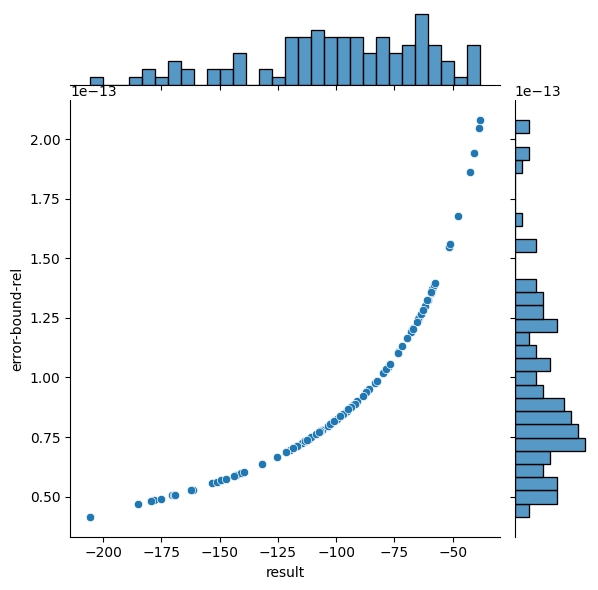

In [288]:
samples_df = pd.DataFrame(post_samples[fname], columns = ["result", "error-bound-rel", "error-bound-abs"])
gappa_abs = results_transpose[fname]["gappa-abs"]
gappa_rel = results_transpose[fname]["gappa-rel"]
# convert to rel
g = sns.jointplot(samples_df, x = "result", y = "error-bound-rel", kind="scatter", marginal_kws={"fill": True, "bins": 30})
g.savefig(f"{fname}.svg")

In [248]:
gappa_rel

nan

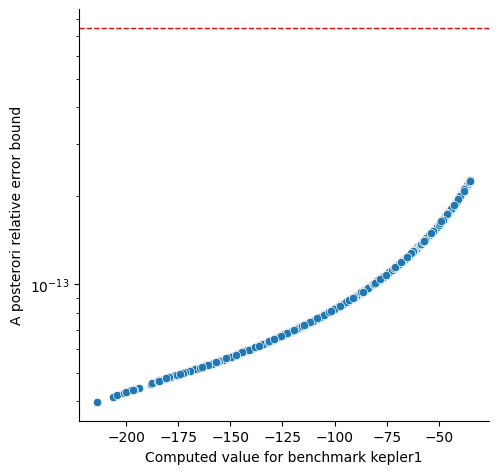

In [450]:
gappa_abs = results_transpose[fname]["gappa-abs"]
gappa_rel = results_transpose[fname]["gappa-rel"]
# convert to rel
g = sns.relplot(samples_df, x = "result", y = "error-bound-rel")
g.set_axis_labels(f"Computed value for benchmark {fname}", "A posterori relative error bound")
ax = g.ax
ax.axhline(y=gappa_abs, linestyle="--", color="red", linewidth=1)
g.set(yscale="log")

In [232]:
fname

'kepler1'

In [233]:
results_transpose[fname]["gappa-abs"]

5.381494361245132e-13

In [234]:
results_transpose[fname]["gappa-abs"]

5.381494361245132e-13

In [179]:
parse_gappa_out(f"../benchmarks-new/{fname}-abs.g.out")[1]

5.381494361245132e-13

(-134.93458819965818, 6.239453398393574e-14)

In [37]:
pd.DataFrame(results)

,benchmark,pre-rel,pre-abs,pre-rel-factor,pre-abs-factor,gappa-abs,gappa-rel
0,sum,None,2.6645352591003757e-14,None,1.3322676295501878e-14,3.663736e-15,NaN
1,kepler0,None,9.53407663928374e-13,None,6.810054742345528e-13,1.231726e-13,NaN
2,shoelace-formula,None,3.996806885453452e-9,None,1.998403442726726e-9,NaN,NaN
3,add-assoc,6.661338147750937e-16,2.6645352591003757e-12,4.440892098500625e-16,1.7763568394002505e-12,6.821210e-13,3.330669e-16
4,himmilbeau,None,1.1224354778960333e-11,None,5.986322548778844e-12,1.000089e-12,NaN
5,sineOrder3,None,5.937035405398565e-15,None,4.2407393152643635e-15,8.886006e-16,NaN
6,matrixDeterminant2,None,2.2648549702353193e-11,None,6.661338147750939e-12,3.502976e-12,NaN
7,rigidBody1,None,9.79216707719388e-13,None,8.160139230994901e-13,2.948752e-13,NaN
8,delta4,None,1.1438511683081742e-12,None,5.004348861348262e-13,1.393602e-13,NaN
9,sqroot,3.774758283725525e-15,4.85722573273506e-15,1.332267629550187e-15,1.734723475976807e-15,5.707240e-16,6.609459e-16


In [38]:
pd.DataFrame(timings)

,gappa-abs,gappa-rel,numfuzz,numfuzz-factor,fptaylor
0,0.105900,NaN,0.007102,None,0.829767
1,0.123544,NaN,0.009509,None,3.413505
2,NaN,NaN,0.021862,None,0.024149
3,0.019700,0.042746,0.006446,None,NaN
4,0.233510,NaN,0.005215,None,0.043843
5,0.028029,NaN,0.003906,None,0.031735
6,0.312490,NaN,0.016237,None,24.484982
7,0.033758,NaN,0.004899,None,0.292203
8,0.179034,NaN,0.010954,None,0.580256
9,0.305686,0.040217,0.005942,None,0.018666
